Found 2 images to process
Processing 1/2: 20250331_MR_Synth7_0013.tif


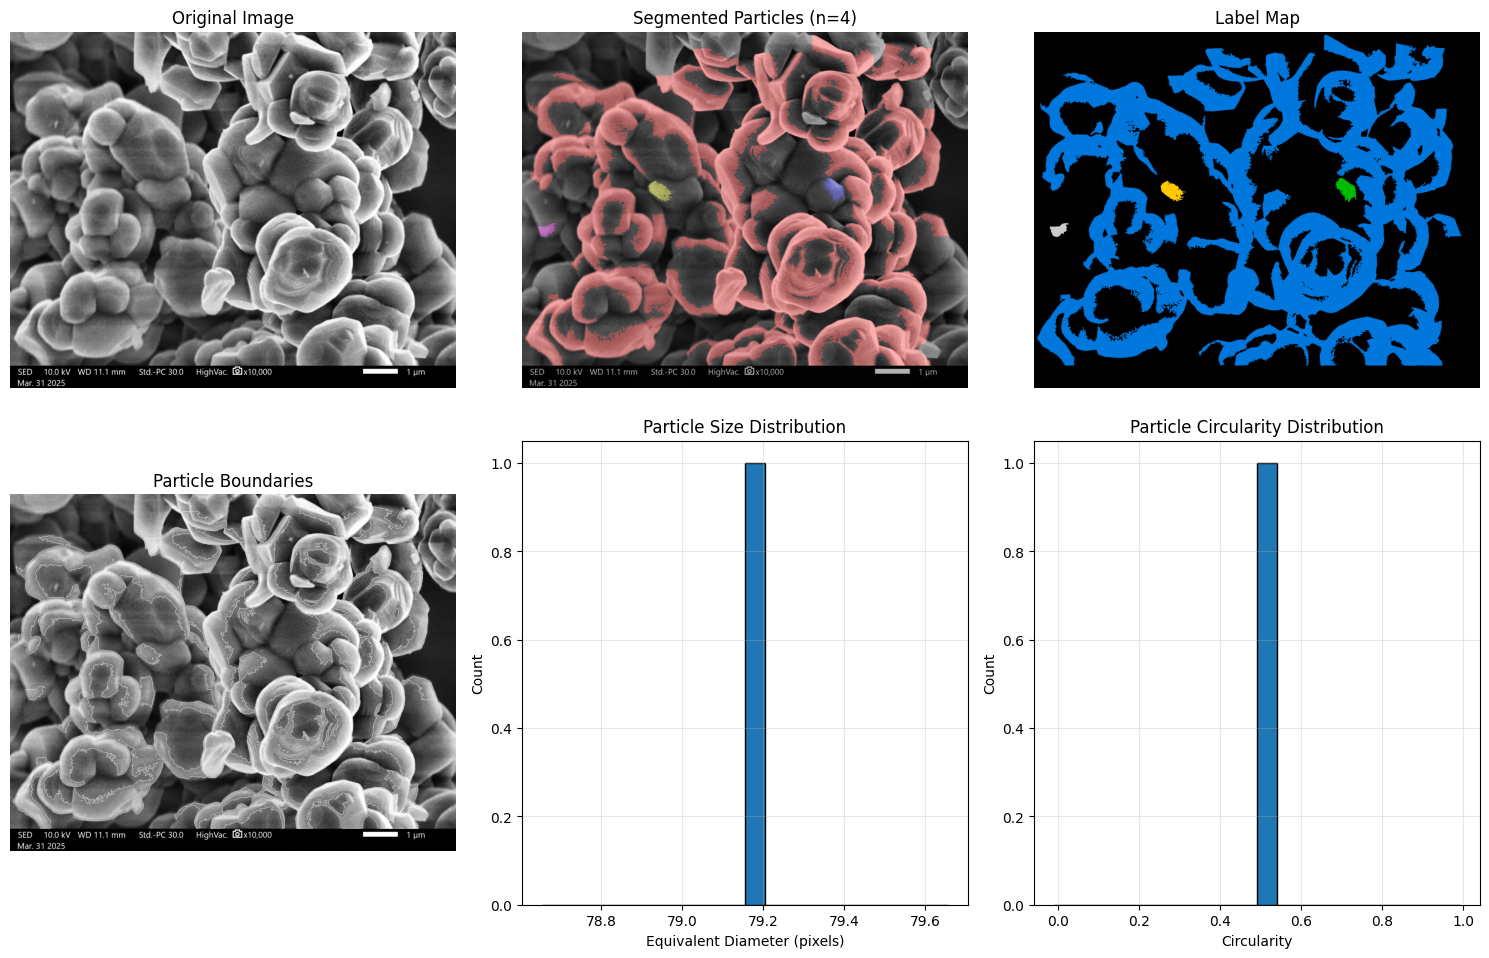

Processing 2/2: 20250331_MR_Synth7_0008.tif


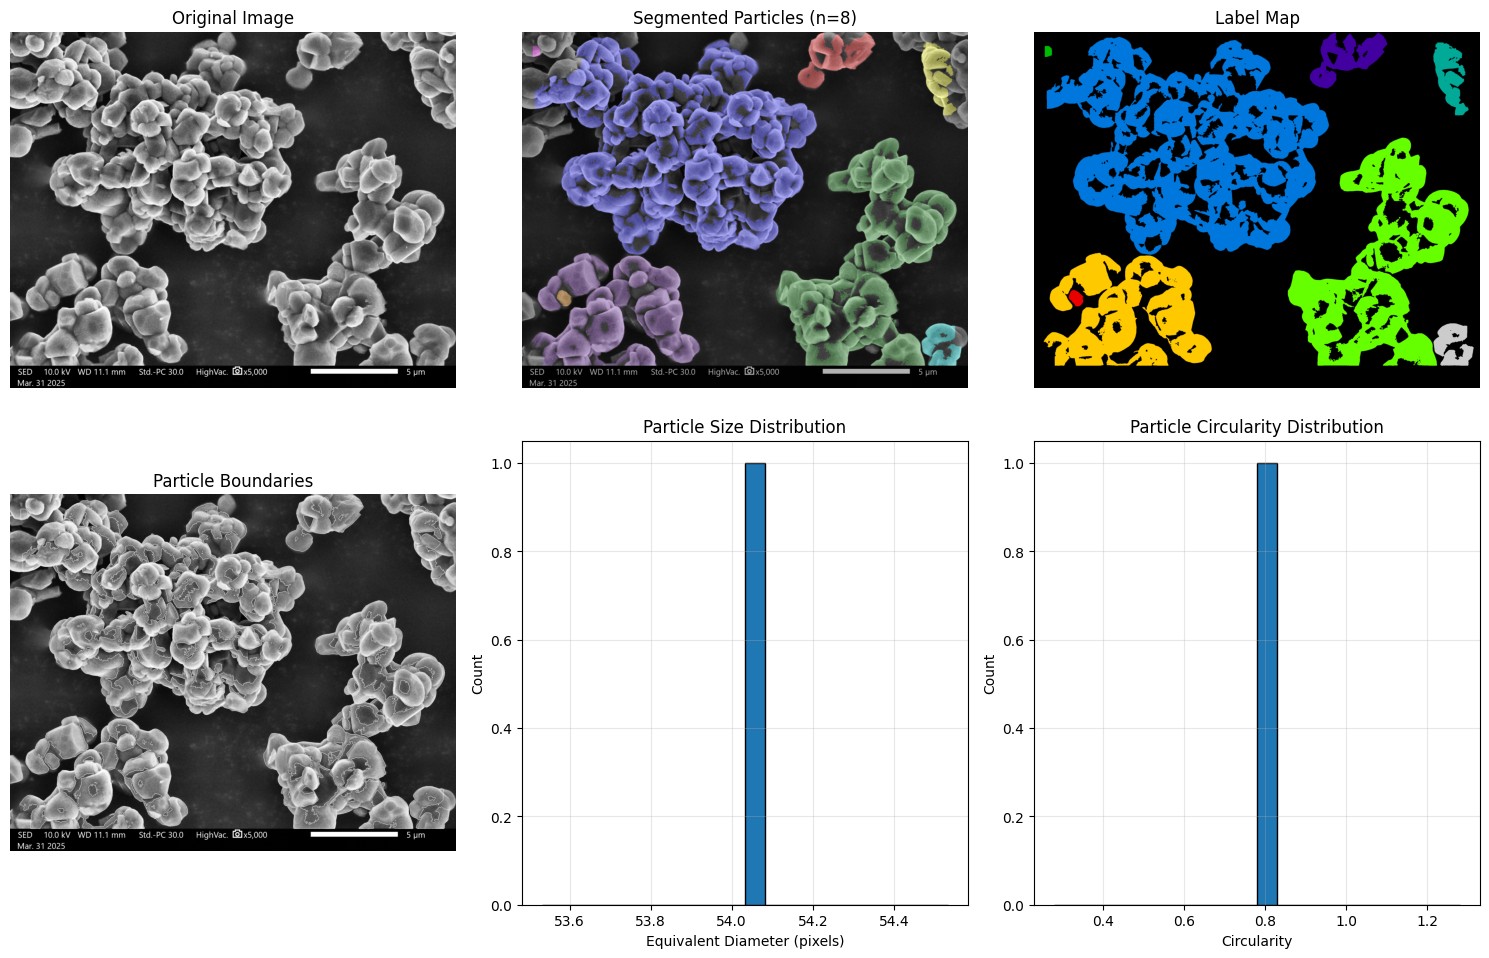


Processed 2 images successfully
Total particles detected: 2

=== Particle Statistics ===
Total particles: 2
Mean area: 3607.00 ± 1858.28 pixels²
Mean diameter: 66.59 ± 17.76 pixels
Mean circularity: 0.636 ± 0.204
Mean aspect ratio: 1.59 ± 0.17


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
# from scipy.watershed import watershed # Removed
from skimage import measure, morphology, feature, segmentation, color # Updated
from skimage.filters import threshold_otsu, gaussian, median, sobel
from skimage.morphology import remove_small_objects, binary_erosion, binary_dilation
import pandas as pd
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

class LNOParticleSegmenter:
    """
    Comprehensive segmentation pipeline for LNO particles in SEM images.
    Combines classical watershed and optional deep learning approaches.
    """

    def __init__(self, min_particle_area=50, max_particle_area=5000):
        self.min_particle_area = min_particle_area
        self.max_particle_area = max_particle_area
        self.results = []

    def preprocess_image(self, img):
        """Enhanced preprocessing for SEM images"""
        # Convert to grayscale if needed
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Normalize to 0-255 range
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_enhanced = clahe.apply(img_norm)

        # Denoise while preserving edges
        img_denoised = cv2.bilateralFilter(img_enhanced, 9, 75, 75)

        return img_denoised

    def remove_background(self, img):
        """Advanced background removal"""
        # Multi-scale Gaussian filtering
        blur1 = gaussian(img, sigma=1)
        blur2 = gaussian(img, sigma=3)

        # Adaptive thresholding
        thresh_otsu = threshold_otsu(blur1)
        binary = blur1 > thresh_otsu

        # Morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        binary = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        # Remove small objects
        binary = remove_small_objects(binary.astype(bool), min_size=self.min_particle_area)

        return binary.astype(np.uint8)

    def watershed_segmentation(self, img, binary_mask):
        """
        Advanced watershed segmentation for overlapping particles
        """
        # Distance transform
        dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)

        # Find peaks (particle centers) using local maxima
        # Adjust h_maxima threshold based on particle size
        h = 0.3 * dist_transform.max()
        coordinates = feature.peak_local_max(
            dist_transform,
            min_distance=10,  # Minimum distance between peaks
            threshold_abs=h,
            # indices=True # Removed indices
        )

        # Create markers from peaks
        markers = np.zeros(dist_transform.shape, dtype=np.uint32)
        for i, coord in enumerate(coordinates):
            markers[coord[0], coord[1]] = i + 1

        # Dilate markers slightly
        markers = ndimage.maximum_filter(markers, size=3)

        # Apply watershed
        labels = segmentation.watershed(-dist_transform, markers, mask=binary_mask) # Updated

        return labels, dist_transform

    def gradient_watershed_segmentation(self, img, binary_mask):
        """
        Alternative: Gradient-based watershed for better boundary detection
        """
        # Calculate gradient magnitude
        gradient = sobel(img)

        # Markers from distance transform
        dist = ndimage.distance_transform_edt(binary_mask)
        coords = feature.peak_local_max(
            dist,
            min_distance=8,
            footprint=np.ones((5, 5)),
            labels=binary_mask,
            # indices=True # Removed indices
        )
        mask = np.zeros(dist.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndimage.label(mask)

        # Watershed on gradient
        labels = segmentation.watershed(gradient, markers, mask=binary_mask) # Updated

        return labels

    def cellpose_segmentation(self, img):
        """
        Deep learning segmentation using Cellpose (optional - requires installation)
        Install with: pip install cellpose
        """
        try:
            from cellpose import models

            # Use cyto2 model which works well for particle-like objects
            model = models.Cellpose(gpu=False, model_type='cyto2')

            # Run segmentation
            masks, flows, styles, diams = model.eval(
                img,
                diameter=30,  # Adjust based on your particle size
                channels=[0,0],  # Grayscale
                flow_threshold=0.4,
                cellprob_threshold=0.0
            )

            return masks
        except ImportError:
            print("Cellpose not installed. Using watershed only.")
            return None

    def post_process_labels(self, labels):
        """Post-processing to refine segmentation"""
        # Remove small objects
        labels = remove_small_objects(labels, min_size=self.min_particle_area)

        # Remove objects touching the border (optional)
        labels = segmentation.clear_border(labels)

        # Relabel sequentially
        labels, num = measure.label(labels > 0, return_num=True)

        return labels

    def analyze_particles(self, img, labels):
        """
        Comprehensive morphological analysis of segmented particles
        """
        properties = measure.regionprops(labels, intensity_image=img)

        particle_data = []
        for prop in properties:
            # Filter by size
            if self.min_particle_area <= prop.area <= self.max_particle_area:
                # Calculate various morphological features
                perimeter = prop.perimeter
                circularity = 4 * np.pi * prop.area / (perimeter ** 2) if perimeter > 0 else 0

                particle_data.append({
                    'label': prop.label,
                    'area': prop.area,
                    'perimeter': perimeter,
                    'circularity': circularity,
                    'eccentricity': prop.eccentricity,
                    'major_axis': prop.major_axis_length,
                    'minor_axis': prop.minor_axis_length,
                    'aspect_ratio': prop.major_axis_length / prop.minor_axis_length if prop.minor_axis_length > 0 else 1,
                    'solidity': prop.solidity,
                    'equivalent_diameter': prop.equivalent_diameter,
                    'mean_intensity': prop.mean_intensity,
                    'centroid_x': prop.centroid[1],
                    'centroid_y': prop.centroid[0],
                    'orientation': prop.orientation,
                    'bbox': prop.bbox
                })

        return pd.DataFrame(particle_data)

    def visualize_results(self, img, labels, df_particles, save_path=None):
        """Comprehensive visualization of segmentation results"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Original image
        axes[0, 0].imshow(img, cmap='gray')
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')

        # Segmentation overlay
        overlay = color.label2rgb(labels, image=img, bg_label=0) # Updated
        axes[0, 1].imshow(overlay)
        axes[0, 1].set_title(f'Segmented Particles (n={labels.max()})')
        axes[0, 1].axis('off')

        # Labeled particles
        axes[0, 2].imshow(labels, cmap='nipy_spectral')
        axes[0, 2].set_title('Label Map')
        axes[0, 2].axis('off')

        # Particle boundaries
        boundaries = segmentation.find_boundaries(labels)
        img_with_bounds = img.copy()
        img_with_bounds[boundaries] = 255
        axes[1, 0].imshow(img_with_bounds, cmap='gray')
        axes[1, 0].set_title('Particle Boundaries')
        axes[1, 0].axis('off')

        # Size distribution
        axes[1, 1].hist(df_particles['equivalent_diameter'], bins=20, edgecolor='black')
        axes[1, 1].set_xlabel('Equivalent Diameter (pixels)')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Particle Size Distribution')
        axes[1, 1].grid(True, alpha=0.3)

        # Circularity distribution
        axes[1, 2].hist(df_particles['circularity'], bins=20, edgecolor='black')
        axes[1, 2].set_xlabel('Circularity')
        axes[1, 2].set_ylabel('Count')
        axes[1, 2].set_title('Particle Circularity Distribution')
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

        return fig

    def process_single_image(self, img_path, method='watershed', visualize=True):
        """
        Process a single image with selected method
        """
        # Load image
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not load image: {img_path}")

        # Preprocess
        img_processed = self.preprocess_image(img)

        # Remove background
        binary_mask = self.remove_background(img_processed)

        # Segmentation
        if method == 'watershed':
            labels, dist = self.watershed_segmentation(img_processed, binary_mask)
        elif method == 'gradient_watershed':
            labels = self.gradient_watershed_segmentation(img_processed, binary_mask)
        elif method == 'cellpose':
            labels = self.cellpose_segmentation(img_processed)
            if labels is None:
                labels, _ = self.watershed_segmentation(img_processed, binary_mask)
        else:
            raise ValueError(f"Unknown method: {method}")

        # Post-process
        labels = self.post_process_labels(labels)

        # Analyze particles
        df_particles = self.analyze_particles(img_processed, labels)

        # Store results
        self.results.append({
            'image_path': img_path,
            'num_particles': len(df_particles),
            'particles_df': df_particles,
            'labels': labels
        })

        # Visualize if requested
        if visualize:
            save_path = Path(img_path).stem + '_segmented.png'
            self.visualize_results(img_processed, labels, df_particles, save_path)

        return labels, df_particles

    def process_batch(self, image_folder, file_pattern='*.tif', method='watershed'):
        """
        Process multiple images in a folder
        """
        image_folder = Path(image_folder)
        image_files = list(image_folder.glob(file_pattern))

        print(f"Found {len(image_files)} images to process")

        all_results = []
        for i, img_path in enumerate(image_files):
            print(f"Processing {i+1}/{len(image_files)}: {img_path.name}")
            try:
                labels, df = self.process_single_image(
                    img_path,
                    method=method,
                    visualize=(i < 5)  # Only visualize first 5
                )
                all_results.append(df)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

        # Combine all results
        if all_results:
            combined_df = pd.concat(all_results, ignore_index=True)
            combined_df.to_csv('particle_analysis_results.csv', index=False)
            print(f"\nProcessed {len(all_results)} images successfully")
            print(f"Total particles detected: {len(combined_df)}")
            self.print_statistics(combined_df)
        else:
            combined_df = pd.DataFrame() # Initialize combined_df as an empty DataFrame if all_results is empty

        return combined_df

    def print_statistics(self, df):
        """Print summary statistics"""
        print("\n=== Particle Statistics ===")
        print(f"Total particles: {len(df)}")
        print(f"Mean area: {df['area'].mean():.2f} ± {df['area'].std():.2f} pixels²")
        print(f"Mean diameter: {df['equivalent_diameter'].mean():.2f} ± {df['equivalent_diameter'].std():.2f} pixels")
        print(f"Mean circularity: {df['circularity'].mean():.3f} ± {df['circularity'].std():.3f}")
        print(f"Mean aspect ratio: {df['aspect_ratio'].mean():.2f} ± {df['aspect_ratio'].std():.2f}")


# Example usage
if __name__ == "__main__":
    # Initialize segmenter
    segmenter = LNOParticleSegmenter(
        min_particle_area=50,   # Adjust based on your images
        max_particle_area=5000  # Adjust based on your images
    )

    # For single image
    # img_path = "path/to/your/image.tif"
    # labels, df = segmenter.process_single_image(img_path, method='watershed')

    # For batch processing
    image_folder = "/content/lno_particles"
    combined_df = segmenter.process_batch(image_folder, file_pattern='*.tif')

    # Example with synthetic test
    # Create a test image similar to your SEM images
    # test_img = np.zeros((512, 512), dtype=np.uint8)
    # for _ in range(30):
    #     center = (np.random.randint(50, 462), np.random.randint(50, 462))
    #     radius = np.random.randint(10, 30)
    #     cv2.circle(test_img, center, radius, 255, -1)

    # # Add noise and blur to simulate SEM
    # test_img = cv2.GaussianBlur(test_img, (5, 5), 0)
    # noise = np.random.normal(0, 10, test_img.shape)
    # test_img = np.clip(test_img + noise, 0, 255).astype(np.uint8)

    # # Save and process test image
    # cv2.imwrite('test_lno.tif', test_img)
    # labels, df = segmenter.process_single_image('test_lno.tif', method='watershed')
    # print("\nTest segmentation complete!")
    # print(df.head())

In [ ]:
# Version 2

✅ Packages installed and imported successfully!

🔬 LNO PARTICLE SEGMENTATION - GOOGLE COLAB

Choose an option:
1. Run test with synthetic image
2. Upload and process your images
3. Process images from Google Drive

📌 Quick Test: Running on synthetic image...
Creating synthetic test image...
✅ Test image saved as: /content/test_particles.tif


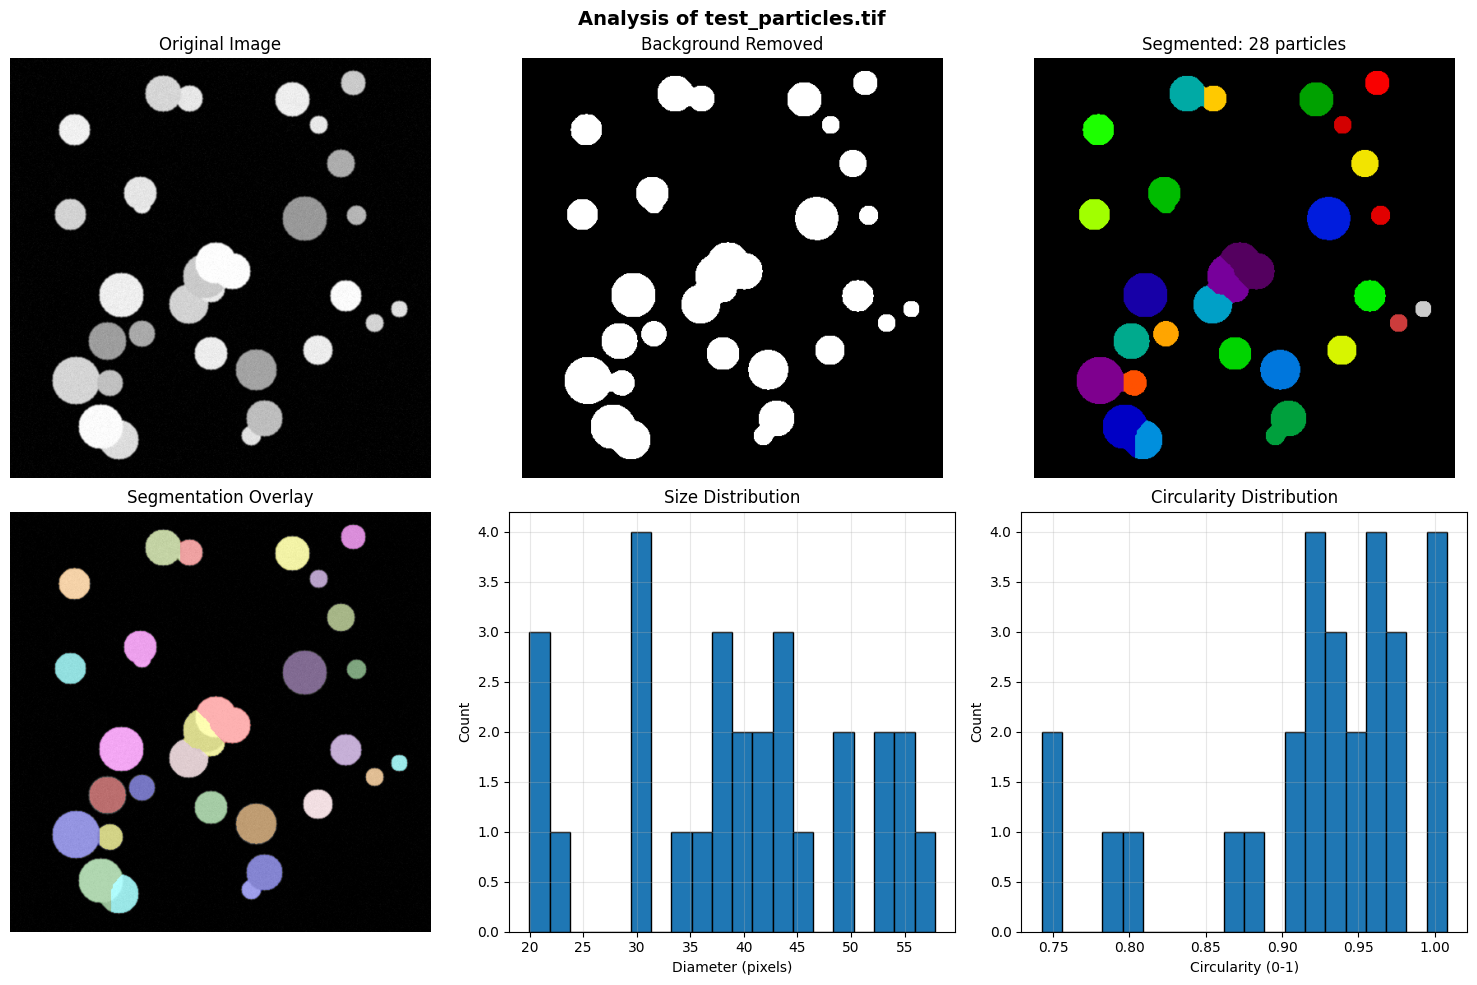


📊 Statistics for test_particles.tif:
   Particles detected: 28
   Mean diameter: 39.4 ± 10.7 pixels
   Mean circularity: 0.923 ± 0.072
   Mean aspect ratio: 1.11 ± 0.21

✅ Setup complete! To process your images, run:
   results = upload_and_process()


In [8]:

!pip install opencv-python scikit-image scipy pandas matplotlib -q

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import distance_transform_edt
from skimage import measure, morphology, feature, segmentation, color # Added color
from skimage.segmentation import watershed
from skimage.filters import threshold_otsu, gaussian, sobel
from skimage.morphology import remove_small_objects
from skimage.color import label2rgb # Imported label2rgb
import pandas as pd
import os
from pathlib import Path
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages installed and imported successfully!")

# ============= PART 2: SIMPLIFIED SEGMENTATION CLASS =============

class SimpleParticleSegmenter:
    """Simplified version optimized for Google Colab"""

    def __init__(self, min_area=100, max_area=5000):
        self.min_area = min_area
        self.max_area = max_area

    def segment_particles(self, img_path, visualize=True):
        """Main segmentation function"""

        # Load image
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                raise ValueError(f"Cannot load image: {img_path}")

        # Store original for visualization
        img_original = img.copy()

        # Step 1: Preprocessing
        # Normalize
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)

        # Denoise
        img = cv2.bilateralFilter(img, 9, 75, 75)

        # Step 2: Background removal
        # Otsu thresholding
        blur = cv2.GaussianBlur(img, (5,5), 0)
        _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Clean up binary mask
        kernel = np.ones((3,3), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        # Remove small objects
        binary_clean = remove_small_objects(binary.astype(bool), min_size=self.min_area)
        binary_clean = binary_clean.astype(np.uint8) * 255

        # Step 3: Watershed segmentation
        # Distance transform
        dist = cv2.distanceTransform(binary_clean, cv2.DIST_L2, 5)

        # Find peaks (centers of particles)
        local_maxima = feature.peak_local_max(
            dist,
            min_distance=10,  # Adjust based on particle size
            threshold_abs=0.3 * dist.max(),
            # indices=True # Removed
        )

        # Create markers
        markers = np.zeros(dist.shape, dtype=np.int32)
        # Convert local_maxima to a numpy array if it's not already
        if not isinstance(local_maxima, np.ndarray):
             local_maxima = np.array(local_maxima)

        # Check if local_maxima is not empty before iterating
        if local_maxima.size > 0:
            for i, peak in enumerate(local_maxima):
                markers[peak[0], peak[1]] = i + 1


        # Expand markers slightly
        markers = cv2.dilate(markers.astype(np.uint8), kernel, iterations=2)

        # Apply watershed
        labels = watershed(-dist, markers, mask=binary_clean)

        # Step 4: Analyze particles
        props = measure.regionprops(labels, intensity_image=img_original)

        particles = []
        for prop in props:
            if self.min_area <= prop.area <= self.max_area:
                particles.append({
                    'particle_id': prop.label,
                    'area_pixels': prop.area,
                    'perimeter': prop.perimeter,
                    'circularity': 4 * np.pi * prop.area / (prop.perimeter ** 2) if prop.perimeter > 0 else 0,
                    'diameter': prop.equivalent_diameter,
                    'eccentricity': prop.eccentricity,
                    'major_axis': prop.major_axis_length,
                    'minor_axis': prop.minor_axis_length,
                    'aspect_ratio': prop.major_axis_length / prop.minor_axis_length if prop.minor_axis_length > 0 else 1,
                    'solidity': prop.solidity,
                    'mean_intensity': prop.mean_intensity,
                    'centroid_x': prop.centroid[1],
                    'centroid_y': prop.centroid[0]
                })

        df = pd.DataFrame(particles)

        # Step 5: Visualization
        if visualize:
            self.visualize(img_original, binary_clean, labels, df, img_path)

        return labels, df

    def visualize(self, img, binary, labels, df, img_path):
        """Create visualization"""

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Original
        axes[0,0].imshow(img, cmap='gray')
        axes[0,0].set_title('Original Image')
        axes[0,0].axis('off')

        # Binary mask
        axes[0,1].imshow(binary, cmap='gray')
        axes[0,1].set_title('Background Removed')
        axes[0,1].axis('off')

        # Segmentation
        axes[0,2].imshow(labels, cmap='nipy_spectral')
        axes[0,2].set_title(f'Segmented: {labels.max()} particles')
        axes[0,2].axis('off')

        # Overlay
        overlay = color.label2rgb(labels, image=img, bg_label=0)
        axes[1,0].imshow(overlay)
        axes[1,0].set_title('Segmentation Overlay')
        axes[1,0].axis('off')

        # Size distribution
        if len(df) > 0:
            axes[1,1].hist(df['diameter'], bins=20, edgecolor='black')
            axes[1,1].set_xlabel('Diameter (pixels)')
            axes[1,1].set_ylabel('Count')
            axes[1,1].set_title('Size Distribution')
            axes[1,1].grid(True, alpha=0.3)

            # Circularity
            axes[1,2].hist(df['circularity'], bins=20, edgecolor='black')
            axes[1,2].set_xlabel('Circularity (0-1)')
            axes[1,2].set_ylabel('Count')
            axes[1,2].set_title('Circularity Distribution')
            axes[1,2].grid(True, alpha=0.3)

        plt.suptitle(f'Analysis of {Path(img_path).name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print statistics
        if len(df) > 0:
            print(f"\n📊 Statistics for {Path(img_path).name}:")
            print(f"   Particles detected: {len(df)}")
            print(f"   Mean diameter: {df['diameter'].mean():.1f} ± {df['diameter'].std():.1f} pixels")
            print(f"   Mean circularity: {df['circularity'].mean():.3f} ± {df['circularity'].std():.3f}")
            print(f"   Mean aspect ratio: {df['aspect_ratio'].mean():.2f} ± {df['aspect_ratio'].std():.2f}")

# ============= PART 3: HELPER FUNCTIONS =============

def create_test_image():
    """Create synthetic test image"""
    print("Creating synthetic test image...")

    img = np.zeros((512, 512), dtype=np.uint8)
    np.random.seed(42)

    # Add random particles
    for _ in range(30):
        x, y = np.random.randint(30, 482, 2)
        r = np.random.randint(10, 30)
        intensity = np.random.randint(150, 255)
        cv2.circle(img, (x, y), r, intensity, -1)

    # Add overlapping particles
    cv2.circle(img, (250, 250), 25, 255, -1)
    cv2.circle(img, (270, 260), 22, 255, -1)

    # Add noise
    img = cv2.GaussianBlur(img, (3, 3), 0)
    noise = np.random.normal(0, 5, img.shape)
    img = np.clip(img + noise, 0, 255).astype(np.uint8)

    # Save
    cv2.imwrite('/content/test_particles.tif', img)
    print("✅ Test image saved as: /content/test_particles.tif")

    return '/content/test_particles.tif'

def upload_and_process():
    """Interactive upload and processing"""
    print("📁 Please select your .tif images to upload:")
    uploaded = files.upload()

    if not uploaded:
        print("No files uploaded!")
        return None

    # Create directory
    os.makedirs('/content/lno_images', exist_ok=True)

    # Save files
    image_paths = []
    for filename, content in uploaded.items():
        path = f'/content/lno_images/{filename}'
        with open(path, 'wb') as f:
            f.write(content)
        image_paths.append(path)

    print(f"\n✅ Uploaded {len(image_paths)} images")

    # Process images
    segmenter = SimpleParticleSegmenter(min_area=100, max_area=5000)
    all_results = []

    for i, img_path in enumerate(image_paths, 1):
        print(f"\n{'='*50}")
        print(f"Processing image {i}/{len(image_paths)}: {Path(img_path).name}")
        print('='*50)

        try:
            labels, df = segmenter.segment_particles(img_path, visualize=True)
            df['image'] = Path(img_path).name
            all_results.append(df)
        except Exception as e:
            print(f"❌ Error: {e}")

    # Combine results
    if all_results:
        combined_df = pd.concat(all_results, ignore_index=True)
        combined_df.to_csv('/content/particle_analysis.csv', index=False)
        print(f"\n✅ Results saved to: /content/particle_analysis.csv")

        # Overall statistics
        print("\n" + "="*50)
        print("📊 OVERALL STATISTICS")
        print("="*50)
        print(f"Total particles analyzed: {len(combined_df)}")
        print(f"Mean diameter: {combined_df['diameter'].mean():.1f} ± {combined_df['diameter'].std():.1f} pixels")
        print(f"Mean circularity: {combined_df['circularity'].mean():.3f}")
        print(f"Mean aspect ratio: {combined_df['aspect_ratio'].mean():.2f}")

        return combined_df

    return None

# ============= PART 4: MAIN EXECUTION =============

print("\n" + "="*60)
print("🔬 LNO PARTICLE SEGMENTATION - GOOGLE COLAB")
print("="*60)
print("\nChoose an option:")
print("1. Run test with synthetic image")
print("2. Upload and process your images")
print("3. Process images from Google Drive")

# Quick test example
print("\n📌 Quick Test: Running on synthetic image...")
test_path = create_test_image()
segmenter = SimpleParticleSegmenter(min_area=100, max_area=5000)
labels, df = segmenter.segment_particles(test_path, visualize=True)

print("\n" + "="*60)
print("✅ Setup complete! To process your images, run:")
print("   results = upload_and_process()")
print("="*60)